In [30]:
import cv2

# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [31]:
import os
# Function to get image file paths and corresponding labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for sub_dir in os.listdir(class_dir):
                sub_dir_path = os.path.join(class_dir, sub_dir)
                if os.path.isdir(sub_dir_path):
                    for img_name in os.listdir(sub_dir_path):
                        img_path = os.path.join(sub_dir_path, img_name)
                        if os.path.isfile(img_path):
                            img = cv2.imread(img_path)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (128, 128))
                            image_paths.append(img/255.0)
                            labels.append(label)
    
    return np.array(image_paths), labels, class_names

In [32]:
# Load and preprocess images
# def load_image(path, label):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [128, 128])
#     return image, label

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_and_labels(dataset_dir):
    image_paths, labels, class_names = get_image_paths_and_labels(dataset_dir)
    images = image_paths
    labels = np.array(labels)
    return images, labels, class_names

# Load original images and labels
original_images, original_labels, class_names = load_images_and_labels(dataset)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training generator (use the same for validation due to small dataset)
train_generator = train_datagen.flow(original_images, original_labels, batch_size=32)

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes: caries, gingivitis, wsl

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(original_labels), y=original_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Callbacks
checkpoint = ModelCheckpoint('keras_best_model.keras', monitor='loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model (using the same data for validation due to small dataset)
history = model.fit(
    train_generator,
    validation_data=train_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


/home/dhawi/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3448 - loss: 1.1300 - val_accuracy: 0.4138 - val_loss: 1.3125
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3793 - loss: 1.2980 - val_accuracy: 0.4138 - val_loss: 1.1698
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4138 - loss: 1.1649 - val_accuracy: 0.3448 - val_loss: 1.1033
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.3448 - loss: 1.1077 - val_accuracy: 0.3448 - val_loss: 1.1859
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3448 - loss: 1.1931 - val_accuracy: 0.3448 - val_loss: 1.1578
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3448 - loss: 1.1622 - val_accuracy: 0.3448 - val_loss: 1.1066
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - accuracy: 0.3448 - loss: 1.1017 - val_accuracy: 0.4138 - val_loss: 1.1160
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4138 - loss: 1.1130 - val_accuracy: 0.4138 - val_loss: 1.1461
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4138 - loss: 1.1096
Training/Validation accuracy: 0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


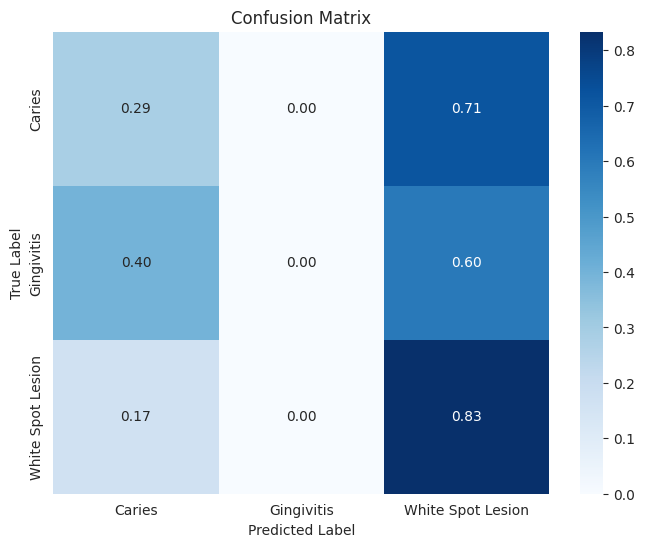

                   precision    recall  f1-score   support

           Caries       0.25      0.29      0.27         7
       Gingivitis       0.00      0.00      0.00        10
White Spot Lesion       0.48      0.83      0.61        12

         accuracy                           0.41        29
        macro avg       0.24      0.37      0.29        29
     weighted avg       0.26      0.41      0.32        29



/home/dhawi/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhawi/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhawi/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

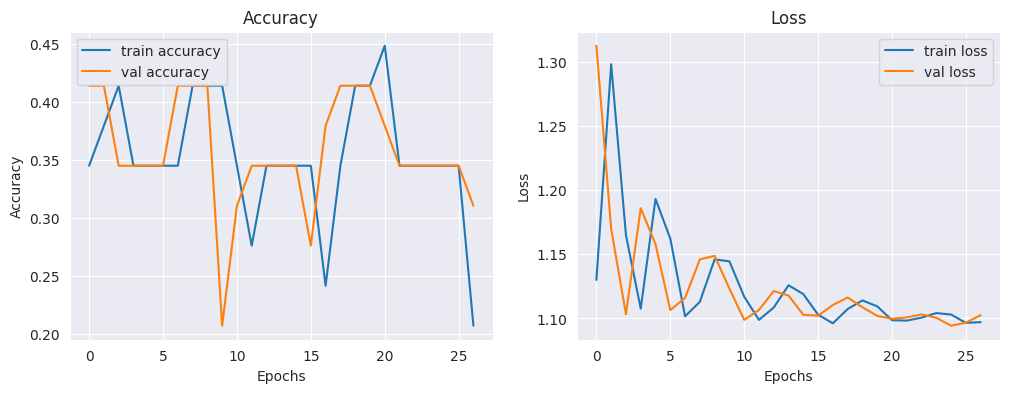

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the training set (acting as validation set)
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Training/Validation accuracy: {train_accuracy:.2f}')

# Generate predictions for the training set
train_pred_probs = model.predict(train_generator)
train_preds = np.argmax(train_pred_probs, axis=1)

# Calculate and plot confusion matrix
cm = confusion_matrix(original_labels, train_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(original_labels, train_preds, target_names=class_names))

# Plotting the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [37]:
original_images[0]

array([[[0.16862745, 0.10196078, 0.07058824],
        [0.18039216, 0.11372549, 0.08627451],
        [0.15686275, 0.11372549, 0.09803922],
        ...,
        [0.67058824, 0.49019608, 0.4       ],
        [0.68627451, 0.51764706, 0.44313725],
        [0.67058824, 0.49411765, 0.41960784]],

       [[0.19607843, 0.14117647, 0.12941176],
        [0.18823529, 0.12156863, 0.09019608],
        [0.20392157, 0.1372549 , 0.10588235],
        ...,
        [0.6745098 , 0.50588235, 0.43921569],
        [0.67843137, 0.50196078, 0.42745098],
        [0.6627451 , 0.48235294, 0.39215686]],

       [[0.2       , 0.13333333, 0.10588235],
        [0.22745098, 0.15294118, 0.1254902 ],
        [0.19607843, 0.14117647, 0.12941176],
        ...,
        [0.68627451, 0.5254902 , 0.45490196],
        [0.68627451, 0.50980392, 0.42745098],
        [0.68627451, 0.50588235, 0.41568627]],

       ...,

       [[0.20392157, 0.18823529, 0.17647059],
        [0.16862745, 0.11764706, 0.09019608],
        [0.15294118, 0